## check .png file

In [2]:
import cv2, os
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#dir = '/media/kevin/Data/Ubuntu/matting_ait/baidu/'
dir = './'
imgList = os.listdir(dir)
assert imgList!=[]

extList = ['.jpg', '.JPG', '.jpeg', '.JPEG','.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tiff']
i=0
for name in imgList:
    prename, ext = os.path.splitext(name)
    if ext !='.png' and ext in extList:
        if os.path.isfile(dir+prename+'.png'):
            print(name)
        else:
            os.rename(dir+name, dir+prename+'.png')
            i+=1
    elif ext not in extList:
        print(name)

print('ext changed: ',i)

clean.py
check.py
.ipynb_checkpoints
movefile.py
Untitled.ipynb
sizecheck.py
ext changed:  1


## move extra bg files to coco_extra

In [59]:
num = 105
src = '/media/kevin/Data/Ubuntu/bgimg_ait/coco_bg/'
dst = '/media/kevin/Data/Ubuntu/coco_extra/'
files = os.listdir(src)
for name in files[:105]:
    os.rename(src+name, dst+name)

## make data list

In [57]:
root = '/home/kevin/git/matting_data/Supervisely/'
imgList = []
maskList = []
i = 0
for subdir in sorted(os.listdir(root)):
    imgPath = os.path.join(root, subdir,'img')
    maskPath = os.path.join(root,subdir,'masks_machine')
    assert os.path.isdir(imgPath)
    assert os.path.isdir(maskPath)
    for name in sorted(os.listdir(imgPath)):
        imgList.append(os.path.join(imgPath, name))
        i+=1
    for name in sorted(os.listdir(maskPath)):
        maskList.append(os.path.join(maskPath, name))
        i+=1
print('count:',i)
with open('super_img.txt','w') as fimg:
    for path in imgList[:-1]:
        fimg.write(path+'\n')
    fimg.write(imgList[-1])
with open('super_msk.txt','w') as fmsk:
    for path in maskList[:-1]:
        fmsk.write(path+'\n')
    fmsk.write(maskList[-1])

count: 9758


In [58]:
root = '/home/kevin/git/matting_data/DIM/img_png/'
paths = []
for file in sorted(os.listdir(root)):
    paths.append(root+file)

with open('DIM_list.txt', 'w') as f:
    for path in paths[:-1]:
        f.write(path+'\n')
    f.write(paths[-1])
    

### bg_list.txt

In [63]:
root = '/media/kevin/Data/Ubuntu/bgimg_ait/'
imgList = []

i=0
for path, subdir, files in os.walk(root):
    for name in files:
        imgList.append(os.path.join(root,path,name))
        i+=1
print('total count:',i)
imgList.sort()
with open('/home/kevin/git/Semantic_Human_Matting/data/bg_list.txt','w') as f:
    for name in imgList[:-1]:
        f.write(name+'\n')
    f.write(imgList[-1])

total count: 45375


## composite image (for DIM)

In [25]:
def composite4(fg, bg, a, w, h):
    fg = np.array(fg, np.float32)
    #bg = np.array(bg[0:h, 0:w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a / 255.
    comp = alpha * fg + (1 - alpha) * bg
    comp = comp.astype(np.uint8)
    return comp


def process(im_name, bg_name, fcount, bcount):
    im = cv.imread(fg_path + im_name)
    a = cv.imread(a_path + im_name, 0)
    h, w = im.shape[:2]
    bg = cv.imread(bg_path + bg_name)
    bh, bw = bg.shape[:2]
    wratio = w / bw
    hratio = h / bh
    ratio = wratio if wratio > hratio else hratio
    #if ratio > 1:
    bg = cv.resize(src=bg, dsize=(math.ceil(bw * ratio), math.ceil(bh * ratio)), interpolation=cv.INTER_CUBIC)
    bh, bw = bg.shape[:2]
    bg = np.array(bg[(bh-h)//2 : (bh-h)//2+h, (bw-w)//2 : (bw-w)//2+w], np.float32)

    out = composite4(im, bg, a, w, h)
    filename = out_path + str(fcount) + '_' + str(bcount) + '.png'
    cv.imwrite(filename, out)

In [28]:
import cv2 as cv
import math

im_name = 'woman1.jpg'
bg_name = 'ait_00026.jpg'
fg_path = 'fg/'
bg_path = './'
a_path = 'mask/'
out_path = './'

process(im_name, bg_name, '1','5')

(713, 770, 3)
(556, 770, 3)


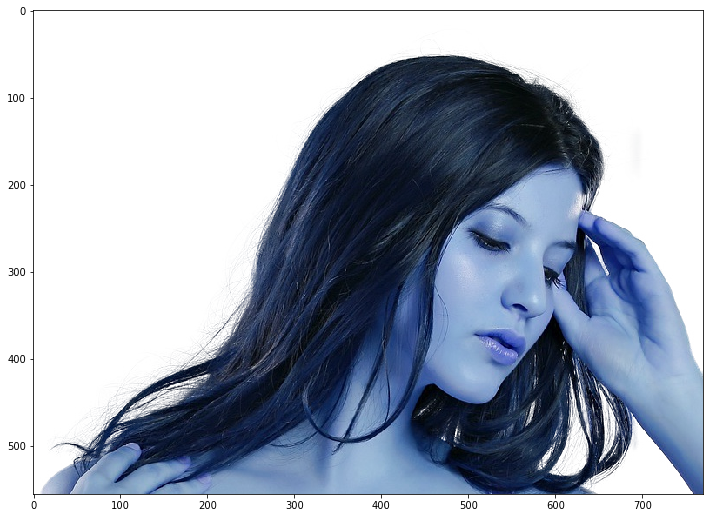

In [52]:
img = 'fg/woman1.jpg'
alpha = 'mask/woman1.jpg'

img = cv2.imread(img)
alpha = cv2.imread(alpha,0)
new = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
new[:,:,3] = alpha

fig = plt.figure(figsize=(12,12))
plt.imshow(new)
#cv2.imwrite('woman1.png', new)

## generate trimap (DIM method)

In [65]:
def generate_trimap(alpha):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    # fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 3))
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv.dilate(unknown, kernel, iterations=1)
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)

True

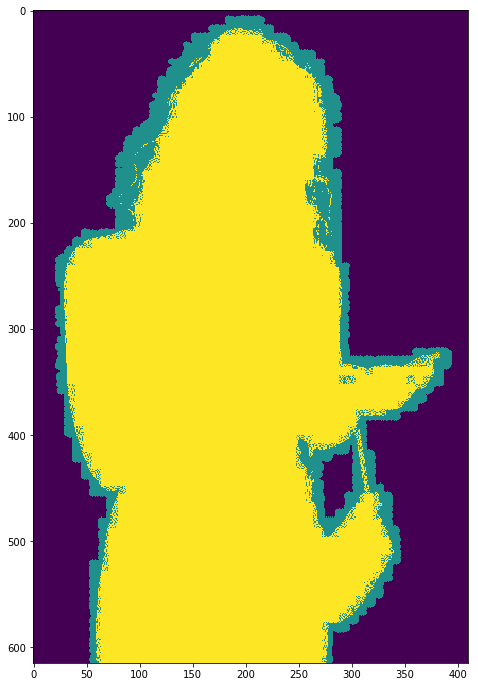

In [67]:
alpha = cv.imread('/home/kevin/git/matting_data/DIM/alpha/1-1252426161dfXY.jpg',0)
trimap = generate_trimap(alpha)

fig = plt.figure(figsize=(12,12))
plt.imshow(trimap)
#cv2.imwrite('/home/kevin/1_coding/img matting/woman_a.png', trimap)

## DIM: img + alpha -> png

In [54]:
fg = '../DIM/images/'
alpha = '../DIM/alpha/'
out = '../DIM/img_png/'

for file in os.listdir(fg):
    img = cv2.imread(fg+file)
    a = cv2.imread(alpha+file, 0)
    assert img!=[] and a!=[]
    new = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    new[:,:,3] = a
    newName = os.path.splitext(file)[0] + '.png'
    cv2.imwrite(out+newName, new)

/home/kevin/.virtualenvs/torch/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


## create dim_list.txt

In [55]:
root = '/home/kevin/git/matting_data/DIM/img_png'
imgList = os.listdir(root)
imgList.sort()

with open('../DIM/DIM_list.txt','w') as f:
    for name in imgList[:-1]:
        f.write(root+name+'\n')
    f.write(root+imgList[-1])
